In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

In [0]:
batch_size = 50

In [3]:
transform = transforms.Compose(
    [transforms.Resize(227), # AlexNet 입력 크기가 224x224 임을 고려
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

170500096it [00:04, 38814479.94it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


torch.Size([50, 3, 227, 227]) torch.Size([50])


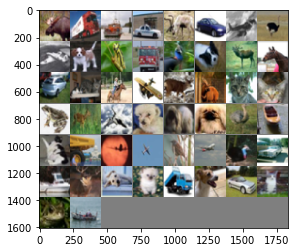

 deer truck  ship   car  deer   car plane  bird plane   dog  frog truck  bird   dog  deer horse   car   cat horse plane  deer  deer   cat   cat  frog  deer plane   dog   dog   dog  bird  ship   cat truck plane plane  bird plane  bird   car  ship  deer   dog   cat truck   dog   car   cat  frog  ship


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape, labels.shape)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
      def __init__(self):
          super(AlexNet, self).__init__()
          self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=11, stride=4)
          #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
          self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
          #torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
          self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
          self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
          self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
          self.conv5 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
          self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
          self.fc1 = nn.Linear(in_features=1152, out_features=256)
          #torch.nn.Linear(in_features, out_features, bias=True)
          self.fc2 = nn.Linear(in_features=256, out_features=64)
          self.fc3 = nn.Linear(in_features=64, out_features=10)

      def forward(self, x):
          x = F.relu(self.conv1(x))
          x = self.pool1(x)
          x = F.relu(self.conv2(x))
          x = self.pool2(x)
          x = F.relu(self.conv3(x))
          x = F.relu(self.conv4(x))
          x = F.relu(self.conv5(x))
          x = self.pool3(x)
          x = x.view(-1, 1152)
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = F.relu(self.fc3(x))
          #torch.nn.softmax(dim=None)

          return x

net = AlexNet()

In [6]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

summary(net, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 55, 55]           5,824
         MaxPool2d-2           [-1, 16, 27, 27]               0
            Conv2d-3           [-1, 32, 27, 27]          12,832
         MaxPool2d-4           [-1, 32, 13, 13]               0
            Conv2d-5           [-1, 64, 13, 13]          18,496
            Conv2d-6           [-1, 64, 13, 13]          36,928
            Conv2d-7           [-1, 32, 13, 13]          18,464
         MaxPool2d-8             [-1, 32, 6, 6]               0
            Linear-9                  [-1, 256]         295,168
           Linear-10                   [-1, 64]          16,448
           Linear-11                   [-1, 10]             650
Total params: 404,810
Trainable params: 404,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.59
Forward/

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

learning_rate = 0.03
optimizer = optim.Adagrad(net.parameters(), lr=learning_rate)

model = net
train_dataset = trainloader
total_epoch = 10

In [0]:
def get_prediction(output):
    return torch.argmax(output, axis=1)

def get_accuracy(pred, label):
    return torch.sum(pred == label).item() / len(label)

In [0]:
from tqdm import tqdm_notebook

def train(model, optimizer, criterion, train_dataset, total_epoch):
    for epoch in range(total_epoch):   # 데이터셋을 수차례 반복합니다.
        tbar = tqdm_notebook(train_dataset, 0)
        for i, data in enumerate(tbar):
            # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
            inputs, labels = data[0].to(device), data[1].to(device)

            # 변화도(Gradient) 매개변수를 0으로 만들고
            optimizer.zero_grad()

            # 순전파 + 역전파 + 최적화를 한 후
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # 통계를 출력합니다.
            running_loss = loss.item()
            if i % 10 == 9:    # print every 100 mini-batches
                pred = get_prediction(outputs)
                train_accuracy = get_accuracy(pred, labels)
                desc = 'epoch%d, loss: %.3f, accuracy: %.2f'%(epoch+1, running_loss, train_accuracy)
                tbar.set_description(desc)

    print('Finished Training')

In [10]:
train(model=model, optimizer=optimizer, criterion=criterion, train_dataset=train_dataset, total_epoch=total_epoch)


Finished Training


In [0]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

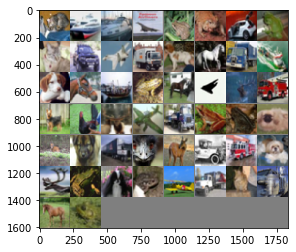

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog  deer   dog truck  bird  deer   car truck   dog  deer  frog   dog  frog plane truck   cat truck horse  frog


In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [13]:
net = AlexNet()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [0]:
outputs = net(images)

In [15]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

Predicted:    cat   car  ship plane   cat truck truck  deer   cat   car plane truck   cat horse truck  ship   dog horse  ship  deer horse plane plane truck  deer  bird  deer horse truck truck   cat   dog  deer   cat truck   car  deer truck truck   dog plane   dog   dog  bird plane truck   cat   cat horse  deer


In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %
